# Import Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras.applications.xception as xception
import zipfile
import sys
import time
import tensorflow.keras as keras
import tensorflow as tf
import re

from PIL import Image
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
from keras.layers.experimental.preprocessing import Normalization
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.layers import Lambda
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

print('setup successful!')

setup successful!


# Define Constants

In [ ]:
IMAGE_WIDTH = 320
IMAGE_HEIGHT = 320
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3
NUM_CLASSES = 12

DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'
LOSS_METRICS=['accuracy']

EARLY_STOP_PATIENCE = 3
BATCH_SIZE_TRAINING = 64
BATCH_SIZE_VALIDATION =64
EPOCHS=50
base_path = "../input/garbage-classification/garbage_classification/"

categories = {
    0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'metal',
    4: 'trash', 5: 'battery', 6: 'shoes', 7: 'clothes',
    8: 'green-glass', 9: 'brown-glass', 10: 'white-glass',
    11: 'biological'
}
NUM_CLASSES = len(categories)

# Create DataFrame

We want to create a data frame that has in one column the filenames of all our images and in the other column the corresponding category.
We Open the directories in the dataset one by one, save the filenames in the filenames_list and add the corresponding category in the categories_list

In [ ]:
# Add class name prefix to filename. So for example "/paper104.jpg" become "paper/paper104.jpg"
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])

    filenames_list = filenames_list  +filenames
    categories_list = categories_list + [category] * len(filenames)

df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print('number of elements = ' , len(df))

number of elements =  15515


In [ ]:
df.head()

,filename,category
0,clothes/clothes2943.jpg,7
1,clothes/clothes1164.jpg,7
2,metal/metal368.jpg,3
3,clothes/clothes460.jpg,7
4,metal/metal221.jpg,3


clothes/clothes2932.jpg


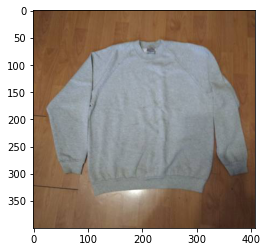

In [ ]:
# see sample image, you can run the same cell again to get a different image
random_row = random.randint(0, len(df)-1)
sample = df.iloc[random_row]
randomimage = image.load_img(base_path +sample['filename'])
print(sample['filename'])
plt.imshow(randomimage)

# Viusalize the Categories Distribution

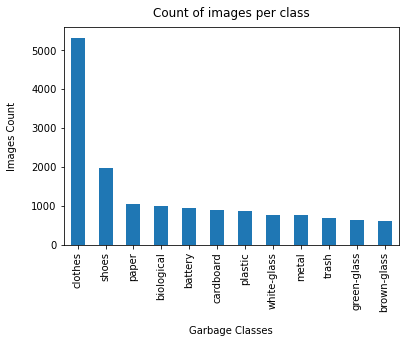

In [ ]:
df_visualization = df.copy()
# Change the catgegories from numbers to names
df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Garbage Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02);

# Split the Data Set

We split the training set into three separate sets:

1. **The training set:** used to train our model.
1. **The validation set**: used to double check that our model is not overfitting the training set, i.e. it can also generalise to other data other than the train data
1. **The Test set:** Used to estimate the accuracy of the model on new data other than the ones the model used for training
For a competition  or for some other cases, you can split the data only to training and validation sets in order to achieve the highest  possible accuracy, without the need to properly estimate how accurate the model really is.

We split the data set as follows: 80% train set, 10% cross_validation set, and 10% test set

In [ ]:
#Change the categories from numbers to names
df["category"] = df["category"].replace(categories)

train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
print(total_validate, test_df.shape[0])

1551 1552


# Data augmentation

We will first create the training data generator, that will get the images from the input data directory to train on them. We will also create a generator for the validation set.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=180,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    width_shift_range = 0.2,
    height_shift_range = 0.2
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df, base_path, x_col='filename', y_col='category',
    target_size=IMAGE_SIZE, class_mode='categorical',
    batch_size=BATCH_SIZE_TRAINING
)

validation_generator = val_test_datagen.flow_from_dataframe(
    validate_df, base_path, x_col='filename', y_col='category',
    target_size=IMAGE_SIZE, class_mode='categorical',
    batch_size=BATCH_SIZE_VALIDATION
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df, base_path, x_col='filename', y_col='category',
    target_size=IMAGE_SIZE, class_mode='categorical',
    batch_size=BATCH_SIZE_VALIDATION, shuffle=False
)


Found 12412 validated image filenames belonging to 12 classes.
Found 1551 validated image filenames belonging to 12 classes.
Found 1552 validated image filenames belonging to 12 classes.


# Create the model

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
weights_path = '/kaggle/input/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = Xception(
    include_top=False,
    weights=weights_path,
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
)
for layer in base_model.layers:
    layer.trainable = False
x= base_model.output
x= GlobalAveragePooling2D()(x)
output = Dense(NUM_CLASSES, activation= DENSE_LAYER_ACTIVATION)(x) # softmax
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=OBJECTIVE_FUNCTION,
              metrics=LOSS_METRICS)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 159, 159, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 159, 159, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 159, 159, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=EARLY_STOP_PATIENCE,
        verbose=1,
        mode='max',
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath='../working/best_garbage_model.hdf5',
        monitor='val_loss',
        save_best_only=True,
        mode='auto',
    )
]

In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
194/194 [==============================] - 451s 2s/step - loss: 1.8569 - accuracy: 0.3966 - val_loss: 1.4052 - val_accuracy: 0.6422
Epoch 2/50
194/194 [==============================] - 384s 2s/step - loss: 1.1986 - accuracy: 0.7052 - val_loss: 0.9680 - val_accuracy: 0.8092
Epoch 3/50
194/194 [==============================] - 386s 2s/step - loss: 0.8986 - accuracy: 0.8000 - val_loss: 0.7511 - val_accuracy: 0.8453
Epoch 4/50
194/194 [==============================] - 384s 2s/step - loss: 0.7434 - accuracy: 0.8305 - val_loss: 0.6273 - val_accuracy: 0.8652
Epoch 5/50
194/194 [==============================] - 386s 2s/step - loss: 0.6451 - accuracy: 0.8453 - val_loss: 0.5495 - val_accuracy: 0.8749
Epoch 6/50
194/194 [==============================] - 386s 2s/step - loss: 0.5869 - accuracy: 0.8526 - val_loss: 0.4974 - val_accuracy: 0.8827
Epoch 7/50
194/194 [==============================] - 387s 2s/step - loss: 0.5395 - accuracy: 0.8619 - val_loss: 0.4579 - val_accuracy: 0.8885

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

# Visualize the training process


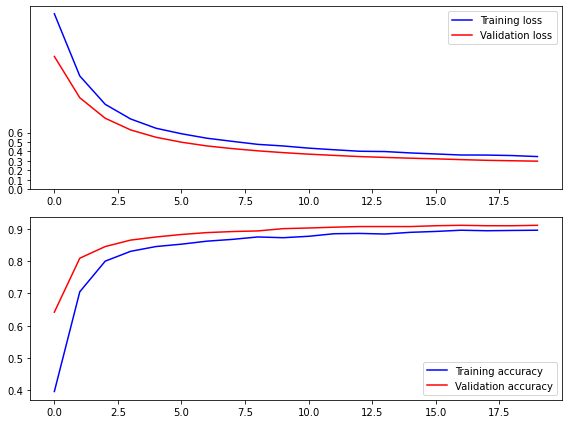

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Loss
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

# Accuracy
ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax2.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Save final model
model.save('garbage_classification_model.h5')

# Evaluate the test

To evaluate the performance of our model we will create a test generator to load the images from the input data directory and evaluate the results.

In [ ]:
filenames = test_generator.filenames
nb_samples = len(filenames)

_, accuracy = model.evaluate_generator(test_generator, nb_samples)

print('accuracy on test set = ',  round((accuracy * 100),2 ), '% ')

accuracy on test set =  91.43 % 


In [ ]:
# get the model's predictions for the test set
preds = model.predict_generator(test_generator, nb_samples)

# Get the category with the highest predicted probability, the prediction is only the category's number and not name
preds = preds.argmax(1)

gen_label_map = {v: k for k, v in test_generator.class_indices.items()}
# Convert the predicted category's number to name
preds = [gen_label_map[item] for item in preds]

# Convert the pandas dataframe to a numpy matrix
labels = test_df['category'].to_numpy()

print(classification_report(labels, preds))

              precision    recall  f1-score   support

     battery       0.93      0.98      0.95        96
  biological       0.91      0.97      0.94       107
 brown-glass       0.79      0.80      0.80        56
   cardboard       0.95      0.88      0.91        82
     clothes       0.97      0.99      0.98       507
 green-glass       0.86      0.64      0.74        67
       metal       0.82      0.90      0.86        72
       paper       0.91      0.86      0.88       122
     plastic       0.81      0.73      0.77        91
       shoes       0.95      0.99      0.97       199
       trash       0.95      0.82      0.88        71
 white-glass       0.71      0.79      0.75        82

    accuracy                           0.91      1552
   macro avg       0.88      0.86      0.87      1552
weighted avg       0.91      0.91      0.91      1552



# Visualize predictions

25/25 [==============================] - 15s 604ms/step - loss: 0.3116 - accuracy: 0.9143

Test Accuracy: 0.9143
Test Loss: 0.3116


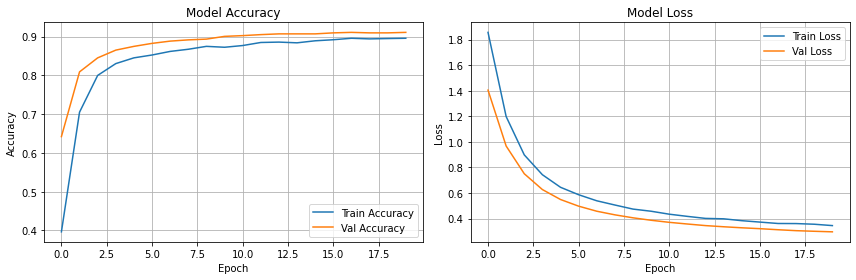

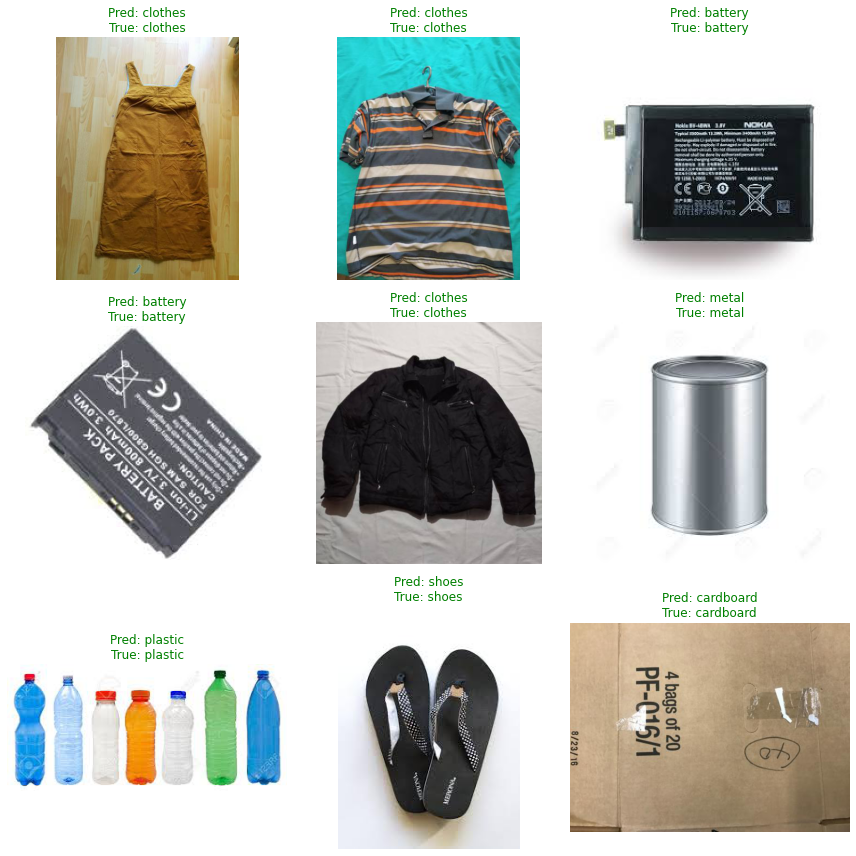

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Evaluate
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Save final model
model.save('garbage_classification_model.h5')

# -----------------------------
# 🎯 Visualize predictions
# -----------------------------
class_labels = list(test_generator.class_indices.keys())

# Predict probabilities
y_pred_probs = model.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Select random images to visualize
n_samples = 9
indices = random.sample(range(len(test_generator.filenames)), n_samples)

plt.figure(figsize=(12, 12))
for i, idx in enumerate(indices):
    img_path = test_generator.filepaths[idx]
    img = plt.imread(img_path)
    true_label = class_labels[test_generator.classes[idx]]
    pred_label = class_labels[y_pred[idx]]

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

Số ảnh bị dự đoán sai: 133 / 1552


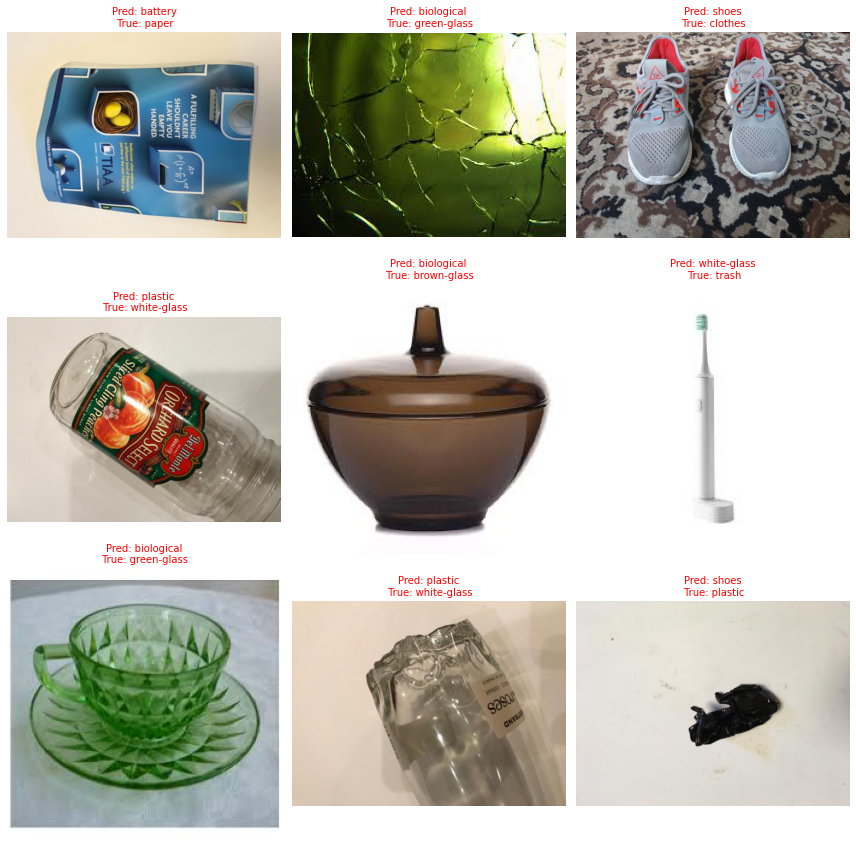

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

class_indices = {v: k for k, v in test_generator.class_indices.items()}

# Tìm các mẫu dự đoán sai
misclassified_indices = np.where(y_pred != y_true)[0]
print(f"Số ảnh bị dự đoán sai: {len(misclassified_indices)} / {len(y_true)}")

# Chọn ngẫu nhiên vài ảnh sai để xem
num_samples = 9
sample_indices = random.sample(list(misclassified_indices), min(num_samples, len(misclassified_indices)))

plt.figure(figsize=(12, 12))
for i, idx in enumerate(sample_indices):
    img_path = test_generator.filepaths[idx]
    img = plt.imread(img_path)

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(
        f"Pred: {class_indices[y_pred[idx]]}\n True: {class_indices[y_true[idx]]}",
        fontsize=10, color="red"
    )
plt.tight_layout()
plt.show()